# Week 5: Rossby waves
### MAQ - 32806, Chiel van Heerwaarden & Imme Benedict, 2016
In this assignment you will study divergence and vorticity near a midlatitude low pressure system. For this, you will use again the ECMWF ERA-Interim data from the 1st of January 2016 0:00. Note the new `get_pressure_index` function. This makes it easier to retrieve data at a certain pressure level.
___
First, we load the required packages.

In [1]:
import numpy as np              # Numpy is the fundamental package for scientific computing in Python.
import netCDF4 as nc            # NetCDF is the data format of the meteorological data that we use.
import matplotlib.pyplot as pl  # Matplotlib is a scientific plotting package.
from mpl_toolkits.basemap import Basemap # Import the map plotting interface.
from ipywidgets import interact
import warnings
warnings.filterwarnings('ignore')

# The statement below enforces the plots to be put into this notebook, instead of in their own windows.
%matplotlib inline
pl.rcParams.update({'font.size': 11})          # Set the standard font size of the plots to 11pt.
pl.rcParams.update({'figure.figsize': [13,5]}) # Set the standard figure size.

___
### Setting up a Python Basemap and read out 3D fields
With the code below, you initialize the world map with the desired coordinates.

In [2]:
# We define a map of the northern hemisphere that is stored in the m object.
lon_start =  -180.
lon_end   =   180.
lat_start =     0.
lat_end   =    85.
m = Basemap(llcrnrlon=lon_start,
            llcrnrlat=lat_start,
            urcrnrlon=lon_end,
            urcrnrlat=lat_end,
            projection='mill', resolution='l')

___

Now, you load the data and read out the desired variables from a NetCDF file from the ECMWF ERA-Interim data archive.

In [3]:
nc_file = nc.Dataset("data/era_data2.nc", "r")
lat = nc_file.variables["latitude"][:]
lon = nc_file.variables["longitude"][:]

nroll = lon.size//2
lon = np.roll(lon, nroll)
lon = np.where(lon>=180., lon-360., lon)

u   = np.roll(nc_file.variables["u"][:,:,:], nroll, -1)
v   = np.roll(nc_file.variables["v"][:,:,:], nroll, -1)
Phi = np.roll(nc_file.variables["z"][:,:,:], nroll, -1)
T   = np.roll(nc_file.variables["t"][:,:,:], nroll, -1)

time = np.arange(0, 28, 0.25)

nc_file.close()

lons, lats = m(*np.meshgrid(lon, lat))

def get_lat_index(lat_plot):
    return abs(lat-lat_plot).argmin()

___
### Plotting the temperature, geopotential and wind vectors
As a starting point you find below the temperature and geopotential at 500 hPa.

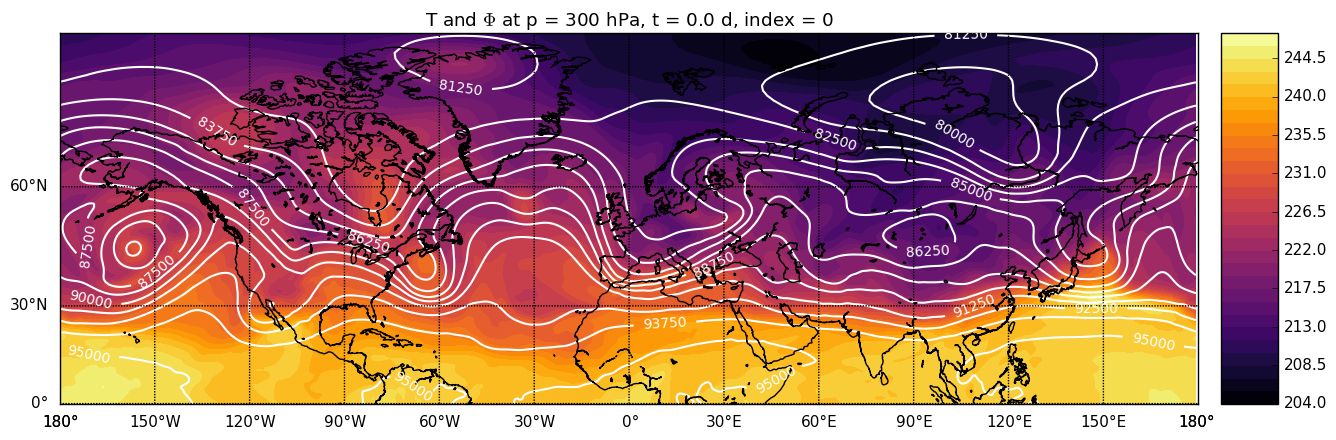

In [14]:
Phi_range = np.arange(50000, 100000, 1250)

def plot_T_map(t=0):
    nt = abs(time-t).argmin()

    pl.figure()
    m.contourf(lons, lats, T[nt,:,:], 31, cmap=pl.cm.inferno)
    m.colorbar()

    cz = m.contour(lons, lats, Phi[nt,:,:], Phi_range, colors='w', linewidths=1.5)
    pl.clabel(cz, fontsize=10., fmt='%1.0f')

    m.drawcoastlines(color='k')
    # draw parallels.
    parallels = np.arange(-90.,90,30.)
    m.drawparallels(parallels,labels=[1,0,0,0])
    # draw meridians
    meridians = np.arange(0.,360.,30.)
    m.drawmeridians(meridians,labels=[0,0,0,1])
    pl.title('T and $\Phi$ at p = 300 hPa, t = {0} d, index = {1}'.format(t, nt));
    pl.tight_layout()
    
interact(plot_T_map, t=(0, 28.75, 0.25));

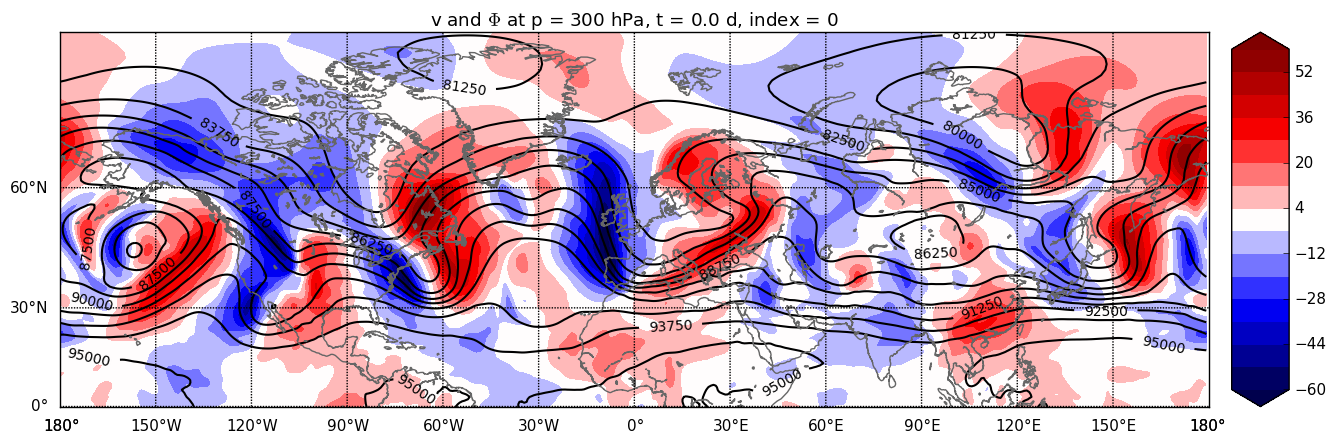

In [15]:
v_range = np.linspace(-60., 60., 16)

def plot_v_map(t=0.):
    nt = abs(time-t).argmin()
    
    pl.figure()
    m.contourf(lons, lats, v[nt,:,:], v_range, cmap=pl.cm.seismic, extend='both')
    m.colorbar()

    cz = m.contour(lons, lats, Phi[nt,:,:], Phi_range, colors='k', linewidths=1.5)
    pl.clabel(cz, fontsize=10., fmt='%1.0f')

    m.drawcoastlines(color='#666666')
    # draw parallels.
    parallels = np.arange(-90.,90,30.)
    m.drawparallels(parallels,labels=[1,0,0,0])
    # draw meridians
    meridians = np.arange(0.,360.,30.)
    m.drawmeridians(meridians,labels=[0,0,0,1])
    pl.title('v and $\Phi$ at p = 300 hPa, t = {0} d, index = {1}'.format(t, nt));
    pl.tight_layout()

interact(plot_v_map, t=(0, 28.75, 0.25));

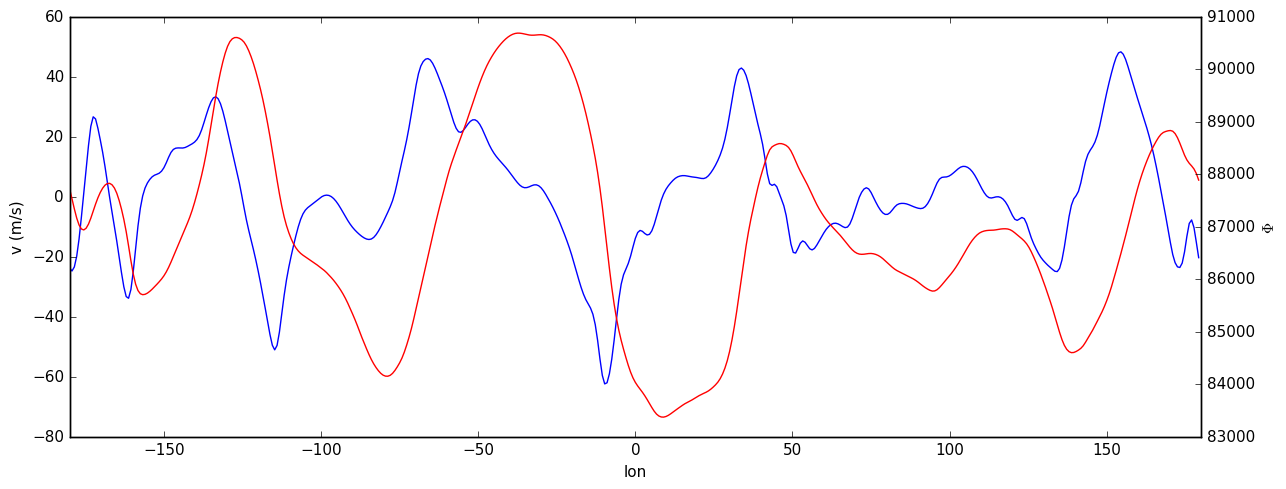

In [17]:
j_lat = get_lat_index(50.)
nt = 0

pl.plot(lon, v[nt,j_lat,:], 'b-')
pl.xlabel('lon')
pl.ylabel('v (m/s)')
pl.twinx()
pl.plot(lon, Phi[nt,j_lat,:], 'r-')
pl.xlim(-180., 180)
pl.ylabel('$\Phi$')
pl.tight_layout()

In [26]:
v_fft = np.fft.rfft(v[nt,j_lat,:]) / lon.size

v_fft_energy = abs(v_fft)**2
v_fft_energy[1:-1] *= 2.

Phi_fft = np.fft.rfft(Phi[nt,j_lat,:]) / lon.size
Phi_fft_energy = abs(Phi_fft)**2
Phi_fft_energy[1:-1] *= 2.

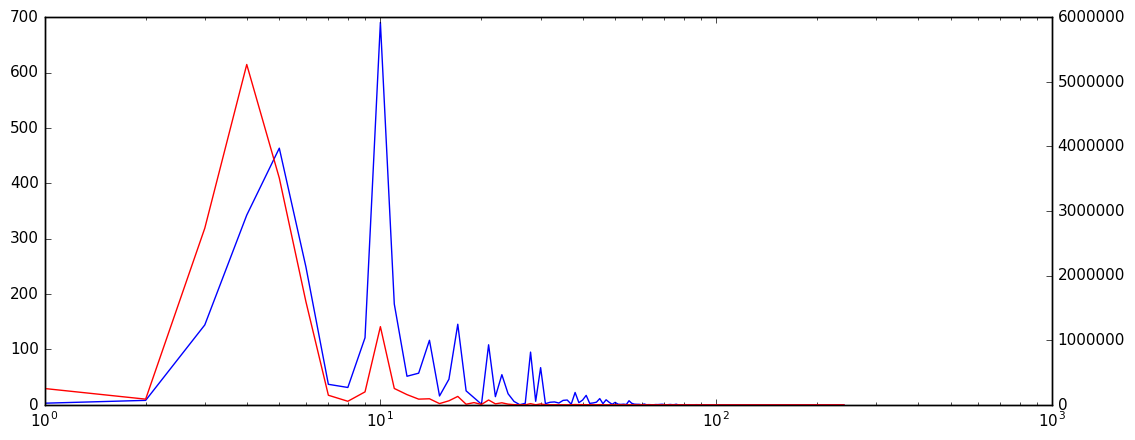

In [30]:
k = np.arange(v_fft_energy.size)
pl.figure()
pl.semilogx(k, k*v_fft_energy, 'b-');
pl.twinx()
pl.semilogx(k, k*Phi_fft_energy, 'r-');

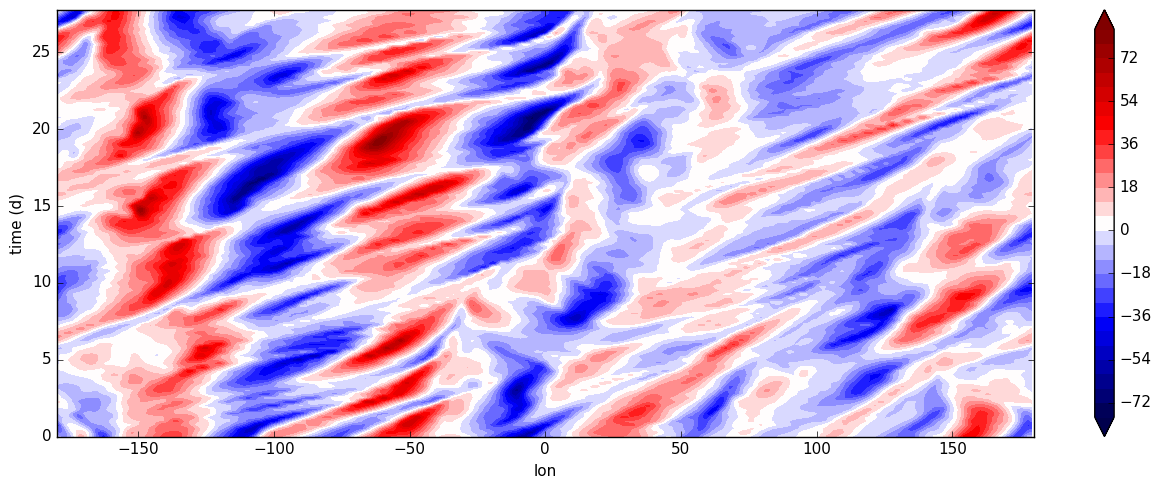

In [33]:
j_lat_lo = get_lat_index(40.)
j_lat_hi = get_lat_index(50.)

v_avg = np.mean(v[:,j_lat_hi:j_lat_lo,:], axis=1)

pl.contourf(lon, time, v_avg, 30, cmap=pl.cm.seismic, extend='both')
pl.xlabel('lon')
pl.ylabel('time (d)')
pl.colorbar()
pl.xlim(-180, 180)
pl.tight_layout()